In [1]:
# from google.colab import drive
# drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
# %cd "/gdrive/My Drive/Colab Notebooks/plate-detector/src"
# %tensorflow_version 1.x
# import tensorflow
# print("tensorflow version :", tensorflow.__version__)

/gdrive/My Drive/Colab Notebooks/plate-detector/src
TensorFlow 1.x selected.
tensorflow version : 1.15.2


In [3]:
from keras.models import Model
from keras.utils import Sequence
from keras.layers import Reshape, Input, Activation, Conv2D, GlobalMaxPool2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Dense, Lambda, ZeroPadding2D, Dropout, DepthwiseConv2D
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers.merge import concatenate
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from imgaug import augmenters as iaa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import copy
import cv2
import os

from Yolo_V2_utils import *
from Yolo_V2_extractors import *
from Yolo_V2_preprocessing import *
from Yolo_V2_detection_head import *

%matplotlib inline

Using TensorFlow backend.


In [4]:
OBJECT = 'Plate'          # Plate / Car / Number
BACKEND = 'SqueezeNet'    # DarkNet, MobileNet, SqueezeNet

ROOT_DIR = '/plate-detector/'
DATA_DIR = ROOT_DIR + 'data/'
MODELS_DIR = ROOT_DIR + 'models/'
BACKEND_DIR = ROOT_DIR + 'backends/'
TEST_DIR = DATA_DIR + "REAL_DATASET/"

SQUEEZENET_BACKEND_PATH = BACKEND_DIR + "squeezenet_backend.h5"
MOBILENET_BACKEND_PATH  = BACKEND_DIR + "mobilenet_backend.h5"

TRAIN_VALID_PROP = 0.8    # Fraction des données qui seront utilisées pour l'entrainement
INPUT_SIZE = 640          # Dimension maximale de l'image
LABELS = [OBJECT]         # Liste des objets que doit YOLO considérer lors de la détection et entrainement
MAX_BOX_PER_IMAGE = 1     # GENERATED 1, MOROCCAN 26
OBJ_THRESH = 0.2          # Valeur minimale de sûreté/fidélité/confidence pour considérer la détéction positive
NMS_THRESH = 0.2          # Valeur minimale de sûreté/fidélité/confidence pour considérer la détéction positive

ANCHORS = [6.45,2.55, 6.54,4.02, 8.37,5.55, 10.17,3.91, 10.66,7.32, 13.16,5.34, 13.47,9.36, 14.92,7.32, 15.33,11.66]

# GENERATED 320 [1.40,0.55, 2.36,0.96, 3.47,1.42, 4.47,1.93, 5.78,2.40, 6.68,3.27, 7.98,2.70, 8.58,3.70, 9.08,4.67]
# GENERATED 640 [2.74,1.10, 4.39,1.83, 6.31,2.65, 8.47,3.61, 11.02,4.59, 12.80,6.18, 15.97,5.34, 16.70,7.28, 18.21,9.28]
# MOROCCAN 1024 [1.61,0.91, 5.37,2.12, 6.37,5.60, 7.61,2.80, 9.20,4.60, 9.89,3.00, 11.66,3.39, 12.68,4.25, 16.94,6.37]
# MOROCCAN RESIZED 512 [0.74,0.42, 2.28,0.93, 3.22,2.92, 3.61,1.25, 4.13,1.81, 5.12,2.64, 5.30,1.53, 6.14,1.91, 9.07,3.15]

In [5]:
model = YOLO(BACKEND, INPUT_SIZE, LABELS, MAX_BOX_PER_IMAGE, ANCHORS)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

(39, 39)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 640, 640, 3)  0                                            
__________________________________________________________________________________________________
squeezenet (Model)              (None, 39, 39, 512)  722496      input_1[0][0]                    
__________________________________________________________________________________________________
Couche_de_detection (Conv2D)    (None, 39, 39, 54)   27702       squeezenet[1][0]                 
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 39, 39, 9, 6) 0           Couche_de_detection[0][0]        
_

In [6]:
weights_file = MODELS_DIR + max(os.listdir(MODELS_DIR))
model.load_weights(weights_file)
print("loaded :", weights_file)

loaded : /gdrive/My Drive/Colab Notebooks/plate-detector/models/EPOCH_97_Validation_0.38.h5


/gdrive/My Drive/Colab Notebooks/plate-detector/src/Yolo_V2_utils.py:195: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-x))


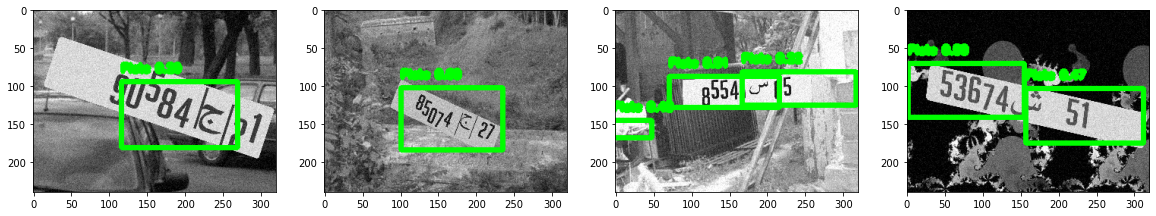

In [7]:
fig=plt.figure(figsize=(20, 20))
test_imgs = os.listdir(TEST_DIR)

columns = 4
rows = 1
i = 1
passed = []

while i < rows*columns +1:
    rand_numb = np.random.randint(0,len(test_imgs)-1)
    if rand_numb in passed :
        continue
    try:
        IMAGE_PATH = TEST_DIR + test_imgs[rand_numb]
        image = cv2.imread(IMAGE_PATH)
        boxes = model.predict(image, OBJ_THRESH, NMS_THRESH)
        image = draw_boxes(image, boxes, LABELS)
        plt_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        fig.add_subplot(rows, columns, i)
        plt.imshow(plt_image)
        passed += [rand_numb]
        i += 1
    except:
        pass

plt.show()
